In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

%matplotlib inline


In [3]:
data = pd.read_csv('adult.csv')
data.shape

(32561, 15)

In [4]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [5]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Data Preprocessing and Modeling


Since we are going to tackle this case as a classification problem, let's encode the variable income into a binary target.

In [6]:
data['target']=data['income'].map({'<=50K':0,'>50K':1})
data.drop("income",axis=1,inplace=True)
data['target'].value_counts()

0    24720
1     7841
Name: target, dtype: int64

In [7]:
# Let's drop "education.num" feature. We will use one-hot encoding instead.
data.drop("education.num",axis=1,inplace=True)

In [8]:
# Since this example is for educational purposes, we'll also drop 'native-country' feature to decrease our data dimensionality.
data.drop('native.country',axis=1,inplace=True)

In [9]:
# Now we will encode categorical features using one-hot encoding, i.e. each category will now be represented by a separate column
# containing only 0 and 1, depending on whether this category is relevant in a sample (row in our data) 
data=pd.get_dummies(data, drop_first = True)

In [10]:
data.head()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,target,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,90,77053,0,4356,40,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,82,132870,0,4356,18,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
2,66,186061,0,4356,40,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,54,140359,0,3900,40,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,41,264663,0,3900,40,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0


Let's split our data into train and test in proportions 70/30. We will also fix random_state for reproducability and use stratify to preserve the same class distribution.

In [11]:
y = data['target'].values
features = [col for col in data.columns if col not in ['target']]
X = data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(22792, 58) (22792,)
(9769, 58) (9769,)


In [12]:
model = RandomForestClassifier(random_state=1).fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy: %.2f" %accuracy_score(y_test, y_pred))
print("Recall: %.2f" %recall_score(y_test, y_pred))

Accuracy: 0.86
Recall: 0.62


In [13]:
import eli5
from eli5.sklearn import PermutationImportance

imp = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(imp, feature_names = X_test.columns.tolist())


ModuleNotFoundError: No module named 'eli5'

In [14]:
# check the target. 1? perfect!
y_test[69]

1

In [15]:
# taking a quick look on a sample
pd.DataFrame(X_test.iloc[69]).T

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
2389,46,243190,7688,0,40,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [16]:

# First, create a prediction on this sample
row = X_test.iloc[69]
to_predict = row.values.reshape(1, -1)

model.predict_proba(to_predict)

array([[0.07, 0.93]])

In [24]:
df = pd.read_csv('adult.csv')

In [25]:
df = df[df.occupation !='?']

In [26]:
df.loc[df['native.country']!='United-States','native.country'] = 'non_usa'

In [27]:
for i in df.columns:
    if type(df[i][1])== str:
        print(df[i].value_counts())

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Name: workclass, dtype: int64
HS-grad         9968
Some-college    6775
Bachelors       5182
Masters         1675
Assoc-voc       1321
11th            1056
Assoc-acdm      1020
10th             831
7th-8th          573
Prof-school      558
9th              463
Doctorate        398
12th             393
5th-6th          303
1st-4th          156
Preschool         46
Name: education, dtype: int64
Married-civ-spouse       14339
Never-married             9912
Divorced                  4258
Separated                  959
Widowed                    840
Married-spouse-absent      389
Married-AF-spouse           21
Name: marital.status, dtype: int64
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-ins

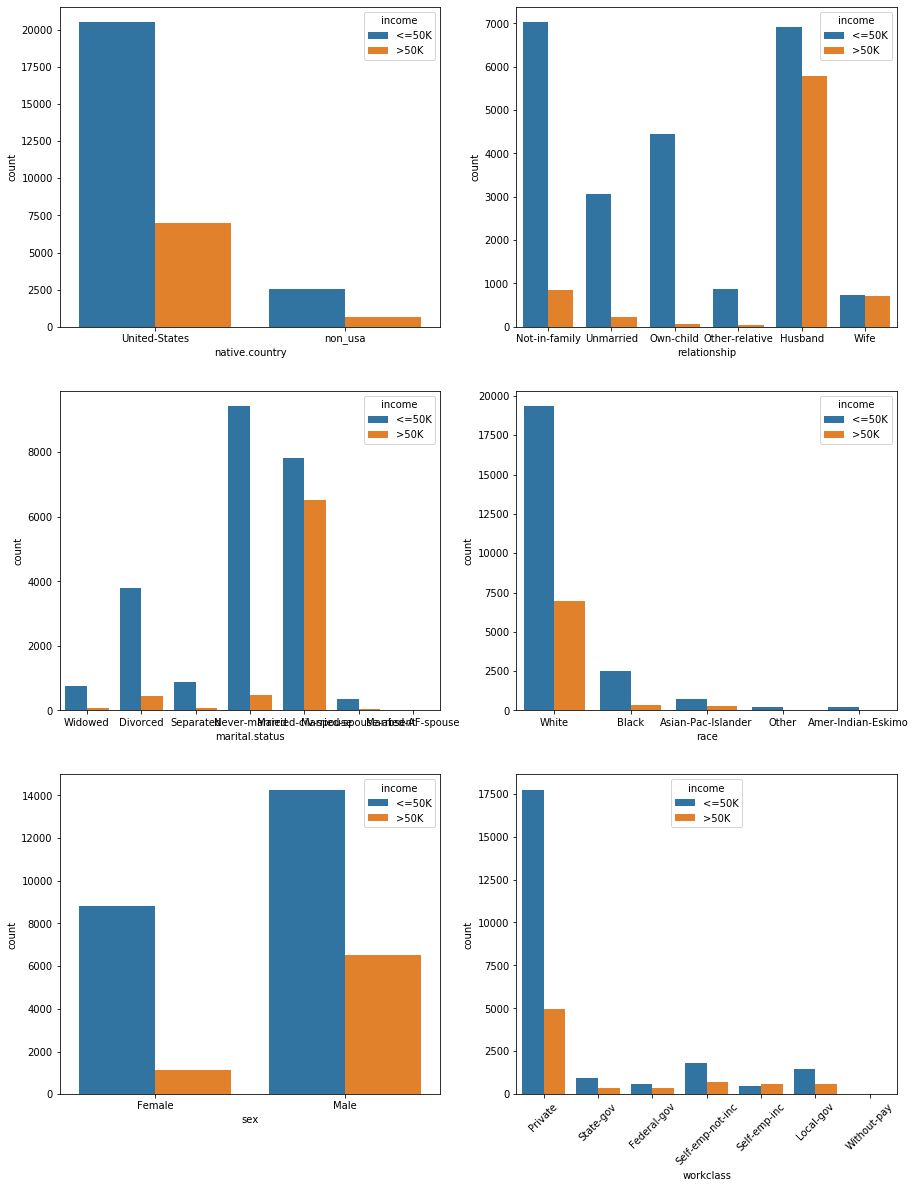

In [28]:
import seaborn as sns
fig, ((a,b),(c,d),(e,f)) = plt.subplots(3,2,figsize=(15,20))
plt.xticks(rotation=45)
sns.countplot(df['workclass'],hue=df['income'],ax=f)
sns.countplot(df['relationship'],hue=df['income'],ax=b)
sns.countplot(df['marital.status'],hue=df['income'],ax=c)
sns.countplot(df['race'],hue=df['income'],ax=d)
sns.countplot(df['sex'],hue=df['income'],ax=e)
sns.countplot(df['native.country'],hue=df['income'],ax=a)


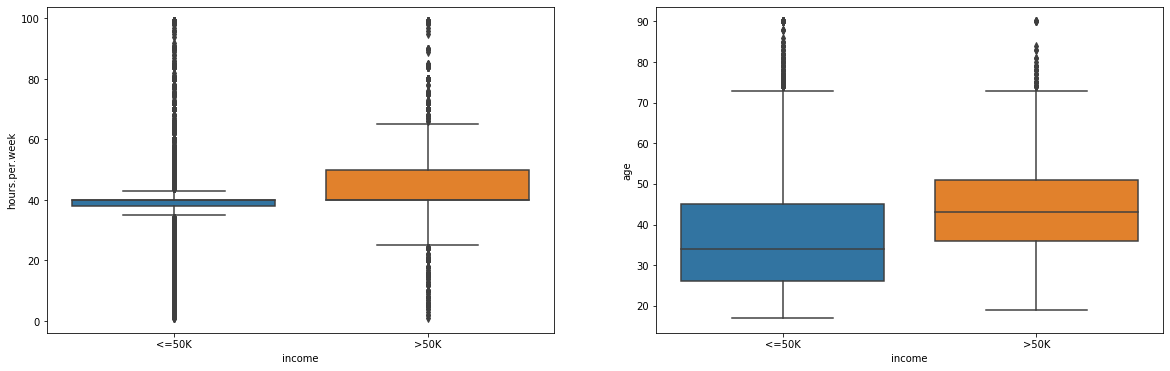

In [29]:
fig, (a,b)= plt.subplots(1,2,figsize=(20,6))
sns.boxplot(y='hours.per.week',x='income',data=df,ax=a)
sns.boxplot(y='age',x='income',data=df,ax=b)